# Préparation du dataset

###**Dossier de travail**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications import vgg16
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings


In [ ]:
# Connecter à googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Choisir le répertoire
dir = os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data')

In [ ]:
df = pd.read_csv('data_propre.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

###**Chargement des données**

In [ ]:
# Chemin vers les données images
path_to_image = "Flipkart/Images/"
image_files  = [file for file in listdir(path_to_image)]
print(len(image_files))

1050


###**Chemin and charge**

In [ ]:
list_labels

['Home Furnishing ',
 'Baby Care ',
 'Watches ',
 'Home Decor & Festive Needs ',
 'Kitchen & Dining ',
 'Beauty and Personal Care ',
 'Computers ']

In [ ]:
os.listdir(dir)

['flipkart_com-ecommerce_sample_1050.csv',
 'data_propre.csv',
 'Flipkart',
 'dataset']

In [ ]:
path = "./dataset/train"
path_test = "./dataset/validation"
os.listdir(path_test)

['Computers ',
 'Beauty and Personal Care ',
 'Kitchen & Dining ',
 'Home Decor & Festive Needs ',
 'Watches ',
 'Baby Care ',
 'Home Furnishing ',
 'val_df.csv']

In [ ]:
data_test = pd.read_csv(path + '/train_df.csv')
data_test = data_test[['Categ_A', "image", "label"]]
data_test.rename(columns = {'Categ_A':'label_name', "image":"image_path"}, inplace = True)
data_test.head(3)

,label_name,image_path,label
0,Home Furnishing,5188dd28a627807407d93549580afb74.jpg,4
1,Computers,a43fbae655e5d13215b9dd65339fa9d4.jpg,2
2,Kitchen & Dining,6b043b37c38f081d96886acb5acfbdf5.jpg,5


In [ ]:
data_val = pd.read_csv(path_test + '/val_df.csv')
data_val = data_val[['Categ_A', "image", "label"]]
data_val.rename(columns = {'Categ_A':'label_name', "image":"image_path"}, inplace = True)
data_val.head()

,label_name,image_path,label
0,Baby Care,3dfd14b667357e26ff6d66761cdc203f.jpg,0
1,Beauty and Personal Care,17a73d7c4b02ada2bfeed1115fed08a4.jpg,1
2,Home Furnishing,597a9549a3e397d52dca62ee47b1f60a.jpg,4
3,Beauty and Personal Care,24e85c590481a7cedfe66597f253f2b2.jpg,1
4,Beauty and Personal Care,59d964c38c787f829c6cfa5629e4df90.jpg,1


In [ ]:
data = df.copy()
data['Categ_A'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [ ]:
# list(set(data['Categ_A']))

['Home Decor & Festive Needs ',
 'Beauty and Personal Care ',
 'Kitchen & Dining ',
 'Computers ',
 'Baby Care ',
 'Watches ',
 'Home Furnishing ']

Home Furnishing 
_____________


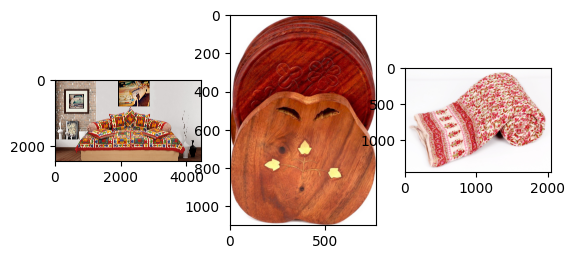

Beauty and Personal Care 
_____________


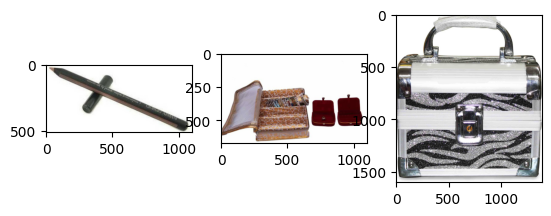

Kitchen & Dining 
_____________


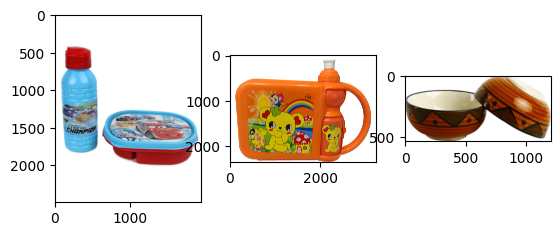

Computers 
_____________


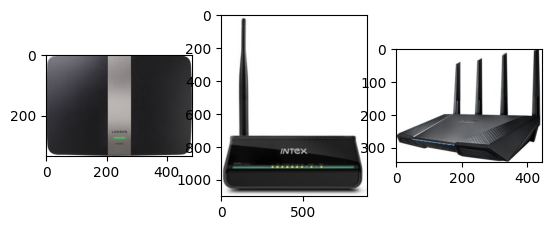

Watches 
_____________


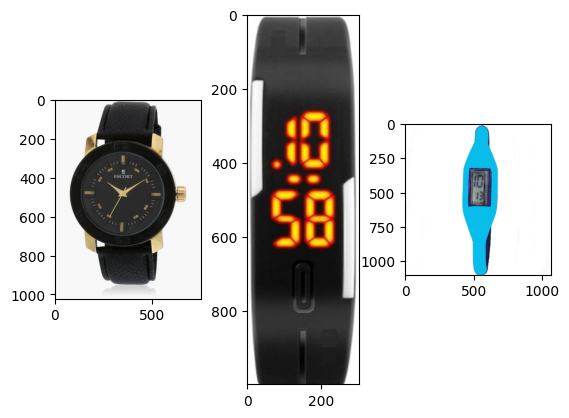

Baby Care 
_____________


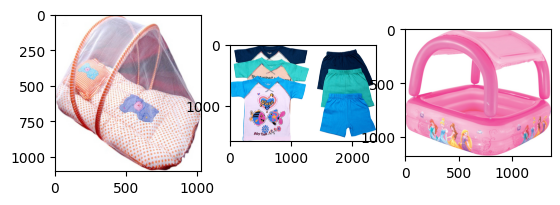

Home Decor & Festive Needs 
_____________


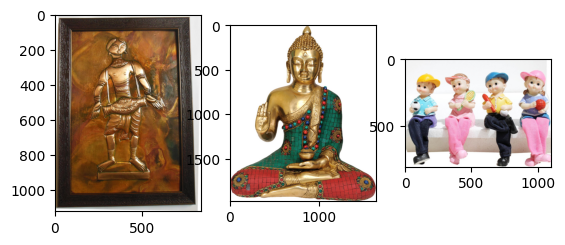

In [ ]:
# Représentons quelques images par catégories
from matplotlib.image import imread

def list_fct(name):
    list_image_name = [data["image"][i]
                       for i in range(len(data)) if data["Categ_A"][i] == name]
    return list_image_name

for categ in list(set(data['Categ_A'])):
    globals()[f'list_{categ}'] = [data["image"][i]
                                  for i in range(len(data)) if data["Categ_A"][i] == categ]

for name in list(set(data['Categ_A'])):
    print(name)
    print("_____________")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path_to_image + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show();

In [ ]:
list_labels = data['label_name'].unique().tolist()
list_labels

['Home Furnishing ',
 'Baby Care ',
 'Watches ',
 'Home Decor & Festive Needs ',
 'Kitchen & Dining ',
 'Beauty and Personal Care ',
 'Computers ']

# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Création des features des images

In [ ]:
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

X = []
for image_num in tqdm(range(len(image_files))):
    # Extraire les features et mettre à jour le dictionnaire
    img = load_img(path_to_image + data["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████| 1050/1050 [04:14<00:00,  4.13it/s]


**Encodage des catégories**

In [ ]:
le = LabelEncoder()
data["label"] = le.fit_transform(data["Categ_A"])

In [ ]:
data[["Categ_A", "label"]].value_counts()

,,count
Categ_A,label,
Baby Care,0,150
Beauty and Personal Care,1,150
Computers,2,150
Home Decor & Festive Needs,3,150
Home Furnishing,4,150
Kitchen & Dining,5,150
Watches,6,150


In [ ]:
data =  data.rename(columns = {'Categ_A':'label_name', "image":'image_path'})
data = data[['label_name', 'image_path', 'label']]
data

,label_name,image_path,label
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,4
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,4
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,4
...,...,...,...
1045,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg,0
1046,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg,0
1047,Baby Care,5912e037d12774bb73a2048f35a00009.jpg,0
1048,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,0


In [ ]:
# Utilisation du modèle pour générer les features
from keras.models import Model

# Paramètres
# include_top = False    # Supprime les couches supérieures pour ajouter ses propres couches de classification
# weights='imagenet'     # Charge les poids pré-entraînés sur ImageNet
# input_shape = (224, 224, 3) # adapter la taille de l'image

# On initialise le modèle avec les paramètres par defaut
VGG16_model = VGG16()

#####**Extraction des Caractéristiques**

In [ ]:
VGG16_model = Model(inputs = VGG16_model.inputs, outputs=VGG16_model.layers[-2].output)

# J'utilise batch_size pour ajuster la mémoire mon GPU
images_features = VGG16_model.predict(X, batch_size=32)

33/33 ━━━━━━━━━━━━━━━━━━━━ 594s 18s/step


## Réduction dimension et analyse

### Réduction de dimension PCA

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 824)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


temps de T-SNE :            19.00 secondes


<ipython-input-19-e96438b0a7fe>:5: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


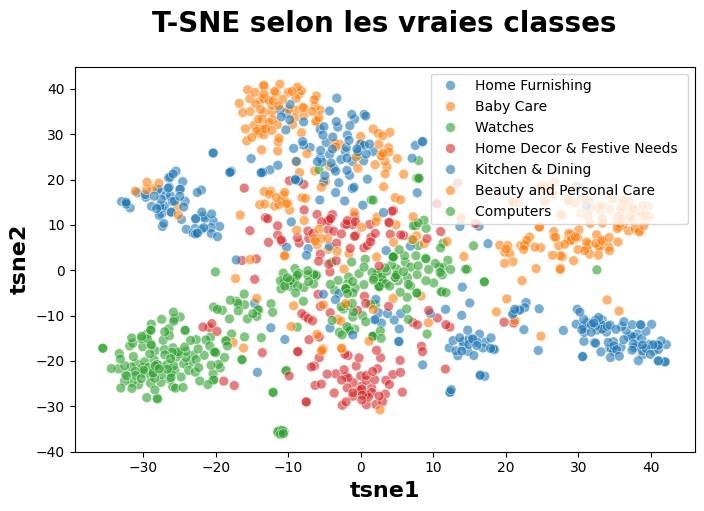

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('T-SNE selon les vraies classes', fontsize = 20, pad = 25, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 10})

plt.show();


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes.

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne



In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

<ipython-input-53-ce182a30b08c>:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


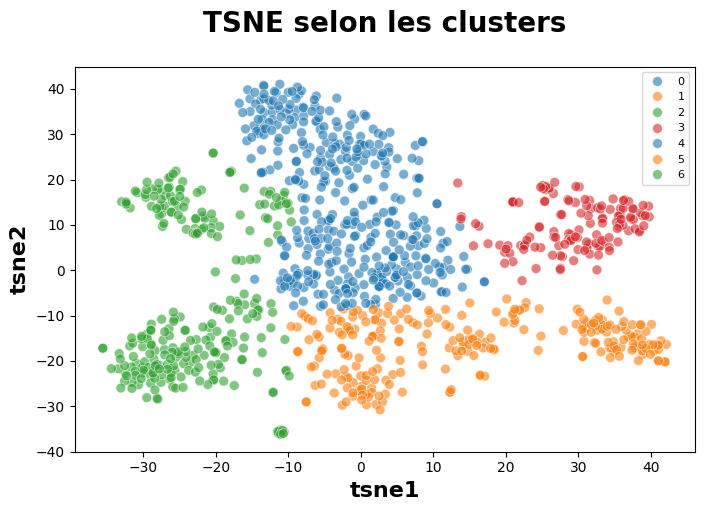

ARI :  0.43844460894948795


In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 20, pad = 25, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 8})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [ ]:
# Analyse d'image "Home Furnishing " affectées au cluster 4 "cloudy"

list_home_furn_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Home Furnishing ') and (df_tsne.iloc[i]['cluster']==4)]
list_home_furn_0[0]

88

tsne1             13.654104
tsne2              9.655272
class      Home Furnishing 
cluster                   4
Name: 88, dtype: object


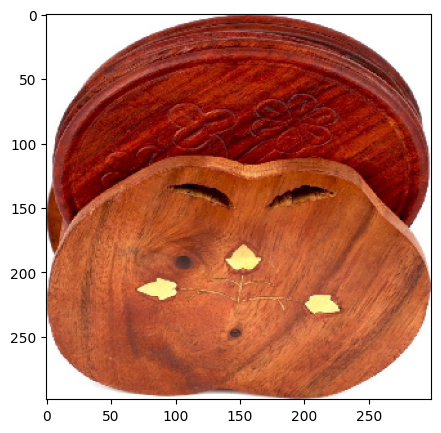

In [ ]:
# Affichage image "shine" considérée comme "cloudy"
id = 88
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))

filename = path_to_image + data["image_path"][id]
image = load_img(filename, target_size=(299, 299))
plt.imshow(image)
plt.show()

### Analyse par classes

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 95   4   1   5  19   5  21]
 [  3   9   2 117  15   1   3]
 [  6  20   9   1 113   0   1]
 [  2  72   8   2  55   2   9]
 [ 73   1   1   0   7   0  68]
 [  0  46   3   4   9  88   0]
 [  0   2 142   1   5   0   0]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 3 6 1 2 5 4]
[[ 95   5  19   4  21   5   1]
 [  3 117  15   9   3   1   2]
 [  6   1 113  20   1   0   9]
 [  2   2  55  72   9   2   8]
 [ 73   0   7   1  68   0   1]
 [  0   4   9  46   0  88   3]
 [  0   1   5   2   0   0 142]]

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       150
           1       0.90      0.78      0.84       150
           2       0.51      0.75      0.61       150
           3       0.47      0.48      0.47       150
           4       0.67      0.45      0.54       150
           5       0.92      0.59      0.72       150
           6       0.86      0.95      0.90       150

    accuracy                           0.66      1050
   macro avg       0.69      0.66      0.66      1050
weighted avg       0.69      0.66      0.66      1050



<Axes: >

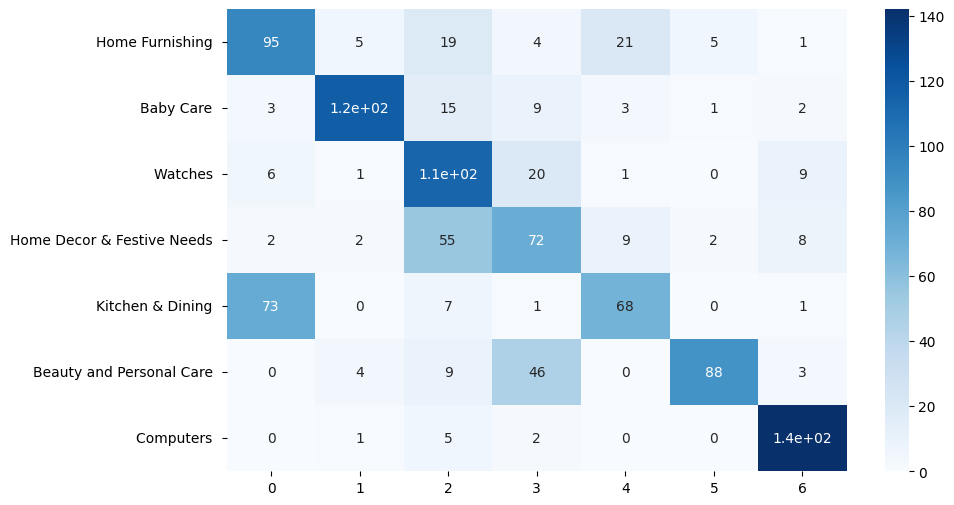

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (10,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
data['label_name'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

* La classe la moins bien prédite est **"Kitchen & Dining"** (l'exemple ci-dessus : confond des articles **Home Furnishing** avec des **Kitchen & Dining**)

In [ ]:
data.shape

(1050, 3)

In [ ]:
# # Séparation en train et validation (70% train, 30% validation par exemple)
# data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

# print(data_train.shape)
# print(data_test.shape)

(735, 3)
(315, 3)


# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


In [ ]:
# Création d'un dossier s'il n'existe pas
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
#     print(f"Le dossier '{save_dir}' a été créé.")

Le dossier '/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data/preview' a été créé.


In [ ]:
# La liste des dossiers existants
# !ls -l "/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialiser l'ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,        # Rotation jusqu'à 30°
    width_shift_range=0.2,    # Translation horizontale jusqu'à 20%
    height_shift_range=0.2,   # Translation verticale jusqu'à 20%
    shear_range=0.2,          # Cisaillement
    zoom_range=0.2,           # Zoom
    horizontal_flip=True,     # Flip horizontal
    fill_mode='nearest'       # Complète les pixels manquants après transformation
)

# Exemple d'application à une image unique
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = load_img(path_to_image + '7b72c92c2f6c40268628ec5f14c6d590.jpg', target_size=(299, 299))  # Charger une image
image_array = img_to_array(image)  # Convertir en tableau numpy
image_array = image_array.reshape((1,) + image_array.shape)  # Redimensionner

# Générer des images augmentées
i = 0
for batch in datagen.flow(image_array, batch_size=1, save_to_dir='preview', save_prefix='aug', save_format='jpeg'):
    i += 1
    if i > 10:  # Générer 10 images augmentées
        break


## Approche préparation initiale des images

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            path_to_image + data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(1050, 224, 224, 3)
(840, 224, 224, 3)


In [ ]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train.shape

(735, 224, 224, 3)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
# Création du callback

model1_save_path1 = "./model1_best_weights.keras"

checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(787, 7)

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.3088 - loss: 8.6844 
Epoch 1: val_loss improved from inf to 1.60424, saving model to ./model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 619s 52s/step - accuracy: 0.3178 - loss: 8.4834 - val_accuracy: 0.7079 - val_loss: 1.6042
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.6454 - loss: 2.1672 
Epoch 2: val_loss did not improve from 1.60424
12/12 ━━━━━━━━━━━━━━━━━━━━ 638s 54s/step - accuracy: 0.6463 - loss: 2.1594 - val_accuracy: 0.7206 - val_loss: 1.7389
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.7205 - loss: 1.6459 
Epoch 3: val_loss improved from 1.60424 to 1.25742, saving model to ./model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 671s 53s/step - accuracy: 0.7215 - loss: 1.6372 - val_accuracy: 0.7651 - val_loss: 1.2574
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.7925 - loss: 0.9832 
Epoch 4: val_loss improved from 1.25742 to 1.06964, saving model to ./mode

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print("________________________")
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 453s 19s/step - accuracy: 0.9973 - loss: 0.0165
Training Accuracy: 0.9946
________________________
10/10 ━━━━━━━━━━━━━━━━━━━━ 179s 18s/step - accuracy: 0.8296 - loss: 1.0858
Validation Accuracy:  0.8444


In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8222
Test Accuracy       :  0.9345


In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of plot-keras-history to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.36-py3-none-any.whl size=9216 sha256=ce98a0122091c515339ee12f07b3cb3e67e6518c6bd527a5e9279ff3b9df1f81
  Stored in directory: /root/.cache/pip/wheels/f2/3d/9d/f6f3bbee314c8cc369277b721b41ac4ab8b790df199ed7d1ad
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.4-py3-none-any.whl size=324285 sha256=2164b95283b6f1dac76da98aa1d5842da1de316cfe2ffdcaa9ddfb61080328e8
  Stored in directory: /root/.cache/pip/wheels/cc/37/0c/923ffeccf1ed550f523bb269e185103538592636861a48

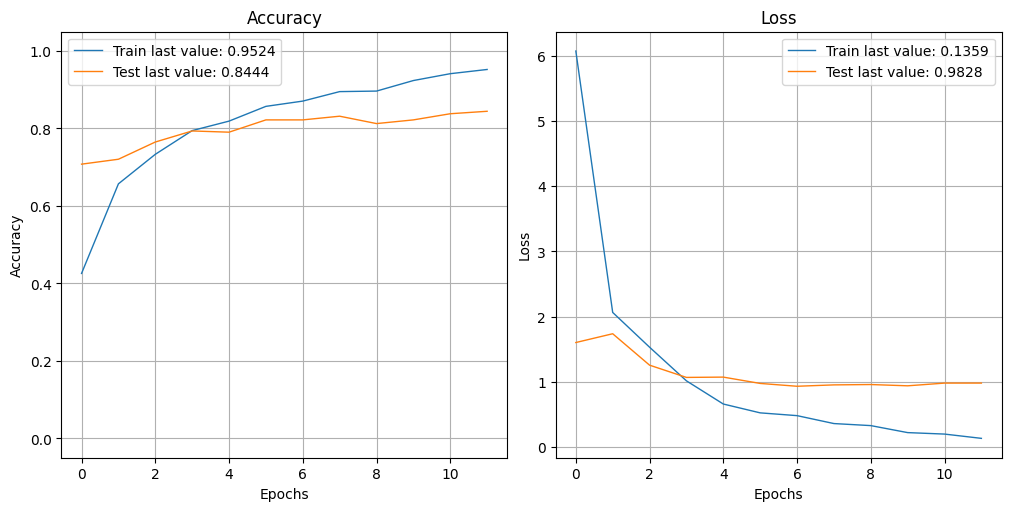

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 198s 20s/step
[2 1 5 0 6 6 3 0 3 3 2 1 3 0 5 4 1 0 0 0 1 3 1 1 0 1 0 6 0 0 1 4 1 2 2 3 2
 4 1 1 0 2 2 5 0 0 5 1 2 1 4 4 5 6 1 3 0 3 5 6 1 1 0 3 1 4 1 4 3 6 5 5 4 6
 1 4 3 1 2 5 4 5 5 6 4 1 3 0 5 2 3 2 4 0 3 1 5 5 2 3 2 6 2 6 5 5 0 5 4 2 4
 3 4 3 6 0 0 6 5 3 5 3 0 5 6 2 5 3 0 4 0 4 4 5 0 3 4 2 5 2 0 4 2 6 1 3 0 4
 6 1 1 2 0 0 1 2 6 1 2 0 2 1 4 3 4 4 2 3 5 6 4 5 3 3 4 4 2 2 5 5 1 3 1 1 4
 6 1 4 5 2 0 5 2 4 2 6 3 6 5 3 6 1 2 0 3 2 6 3 1 6 5 4 3 5 4 0 1 0 1 5 5 0
 3 5 0 0 6 5 0 3 6 0 2 4 6 6 4 2 3 6 6 6 1 0 0 4 1 2 4 0 3 6 6 3 3 5 5 1 4
 1 4 4 3 5 3 6 2 6 6 3 2 2 4 6 0 2 4 5 6 3 2 5 2 4 2 3 1 5 3 4 1 6 0 5 6 6
 2 0 4 6 6 2 0 6 1 4 5 3 1 2 6 2 5 1 6]

[2 1 5 0 2 6 0 0 0 5 1 1 3 0 5 4 2 0 4 0 1 3 1 1 4 1 5 2 0 0 5 0 1 2 2 3 2
 4 1 1 4 2 2 4 0 0 5 1 2 3 4 0 5 6 1 3 0 3 5 6 1 1 0 3 1 0 1 4 3 6 5 5 4 6
 1 4 3 1 2 5 4 2 5 6 0 2 3 0 5 1 5 2 4 5 3 1 5 5 2 3 3 6 2 6 5 5 0 3 4 2 4
 3 4 3 6 0 0 6 5 3 3 3 0 5 6 2 5 3 4 4 0 4 2 5 0 3 4 2 5 2 0 4 2 6 1 3 0 4
 6 1 1 3 0 0 1 2 6

In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[33  1  1  1  7  2  0]
 [ 0 38  3  1  1  2  0]
 [ 0  3 36  6  0  0  0]
 [ 3  0  1 36  0  5  0]
 [ 8  0  2  0 35  0  0]
 [ 1  0  1  3  1 39  0]
 [ 0  1  2  0  0  0 42]]


In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[33  1  1  1  7  2  0]
 [ 0 38  3  1  1  2  0]
 [ 0  3 36  6  0  0  0]
 [ 3  0  1 36  0  5  0]
 [ 8  0  2  0 35  0  0]
 [ 1  0  1  3  1 39  0]
 [ 0  1  2  0  0  0 42]]

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        45
           1       0.88      0.84      0.86        45
           2       0.78      0.80      0.79        45
           3       0.77      0.80      0.78        45
           4       0.80      0.78      0.79        45
           5       0.81      0.87      0.84        45
           6       1.00      0.93      0.97        45

    accuracy                           0.82       315
   macro avg       0.82      0.82      0.82       315
weighted avg       0.82      0.82      0.82       315



<Axes: >

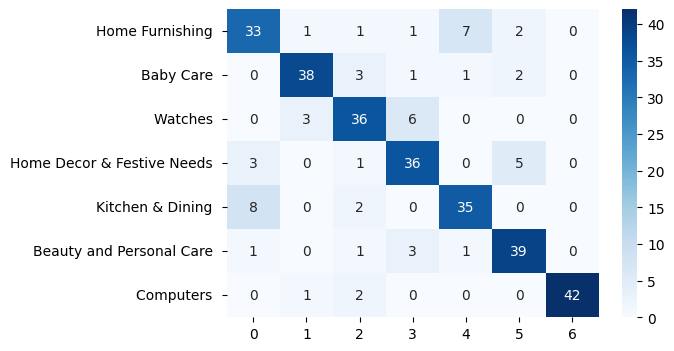

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* La confusion Kitchen & Dining et Home Furnishing est maintenant moins visible.

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
dff = data.copy()

# Ajouter une colonne avec les chemins complets des images
dff['full_image_path'] = dff['image_path'].apply(lambda x: os.path.join(path_to_image, x))
dff.head()

,label_name,image_path,label,full_image_path
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,4,Flipkart/Images/55b85ea15a1536d46b7190ad6fff8c...
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,0,Flipkart/Images/7b72c92c2f6c40268628ec5f14c6d5...
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,0,Flipkart/Images/64d5d4a258243731dc7bbb1eef49ad...
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,4,Flipkart/Images/d4684dcdc759dd9cdf41504698d737...
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,4,Flipkart/Images/6325b6870c54cd47be6ebfbffa620e...


In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(dff, directory='',
                                x_col='full_image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(dff, datagen_train, data_type='training')
val_flow = data_flow_fct(dff, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 1050 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3615 - loss: 6.4644 
Epoch 1: val_loss improved from inf to 2.47674, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 687s 27s/step - accuracy: 0.3672 - loss: 6.3746 - val_accuracy: 0.5191 - val_loss: 2.4767
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6696 - loss: 1.6417 
Epoch 2: val_loss improved from 2.47674 to 1.75581, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 685s 27s/step - accuracy: 0.6696 - loss: 1.6416 - val_accuracy: 0.5725 - val_loss: 1.7558
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7556 - loss: 1.0901 
Epoch 3: val_loss improved from 1.75581 to 1.69179, saving model to ./model2_best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 649s 26s/step - accuracy: 0.7555 - loss: 1.0912 - val_accuracy: 0.5725 - val_loss: 1.6918
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7692 - loss: 0.7792 
Epoch 4: val_loss improved from 1.69

In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9500
Test Accuracy       :  0.8900


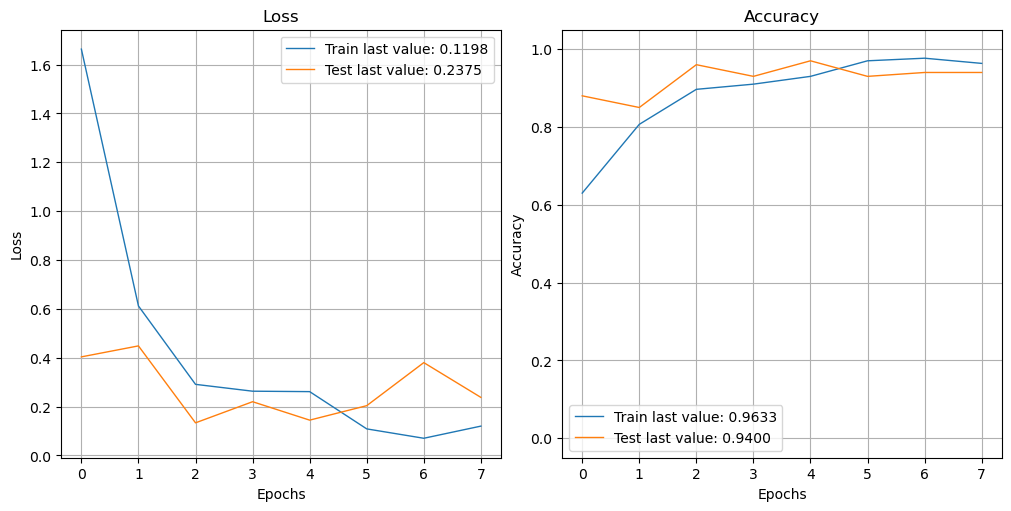

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 400 files belonging to 4 classes.
Using 300 files for training.
Found 400 files belonging to 4 classes.
Using 100 files for validation.
Found 100 files belonging to 4 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 2.7547 - accuracy: 0.5799
Epoch 1: val_loss improved from inf to 0.65452, saving model to .\model3_best_weights.h5
10/10 [==============================] - 3s 188ms/step - loss: 2.6716 - accuracy: 0.5933 - val_loss: 0.6545 - val_accuracy: 0.8400
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.8033
Epoch 2: val_loss improved from 0.65452 to 0.21269, saving model to .\model3_best_weights.h5
10/10 [==============================] - 2s 158ms/step - loss: 0.8903 - accuracy: 0.8033 - val_loss: 0.2127 - val_accuracy: 0.9100
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8833
Epoch 3: val_loss improved from 0.21269 to 0.19603, saving model to .\model3_best_weights.h5
10/10 [==============================] - 2s 159ms/step - loss: 0.5598 - accuracy: 0.8833 - val_loss: 0.1960 - val_accuracy: 0.9100
Epoch 4/50
10/10 [==============================] 

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 1s 95ms/step - loss: 0.0260 - accuracy: 0.9900
Training Accuracy   : 0.9900

4/4 [==============================] - 1s 74ms/step - loss: 0.3030 - accuracy: 0.9500
Validation Accuracy :  0.9500


In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9700
Test Accuracy       :  0.8400


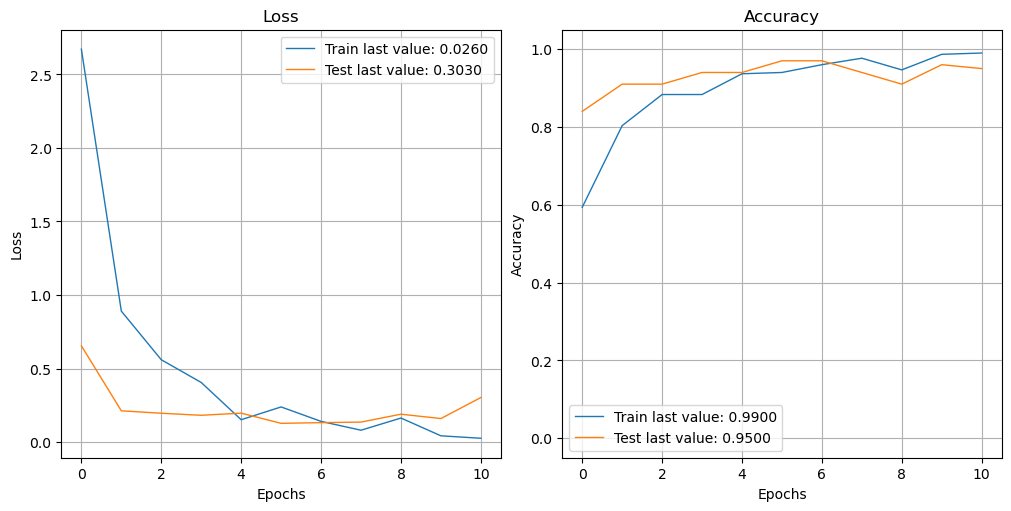

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 400 files belonging to 4 classes.
Using 300 files for training.
Found 400 files belonging to 4 classes.
Using 100 files for validation.
Found 100 files belonging to 4 classes.


In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.07517, saving model to .\model4_best_weights.h5
10/10 [==============================] - 9s 372ms/step - loss: 1.3576 - accuracy: 0.3333 - val_loss: 1.0752 - val_accuracy: 0.6400
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.5967
Epoch 2: val_loss improved from 1.07517 to 0.83699, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 331ms/step - loss: 1.0039 - accuracy: 0.5967 - val_loss: 0.8370 - val_accuracy: 0.7600
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.7367
Epoch 3: val_loss improved from 0.83699 to 0.70421, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 325ms/step - loss: 0.8124 - accuracy: 0.7367 - val_loss: 0.7042 - val_accuracy: 0.8200
Epoch 4/50
10/10 [==============================] 

10/10 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9567
Epoch 19: val_loss improved from 0.26770 to 0.25773, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 338ms/step - loss: 0.1833 - accuracy: 0.9567 - val_loss: 0.2577 - val_accuracy: 0.9200
Epoch 20/50
10/10 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9567
Epoch 20: val_loss improved from 0.25773 to 0.25432, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 335ms/step - loss: 0.1700 - accuracy: 0.9567 - val_loss: 0.2543 - val_accuracy: 0.9300
Epoch 21/50
10/10 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9400
Epoch 21: val_loss improved from 0.25432 to 0.24227, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 332ms/step - loss: 0.2127 - accuracy: 0.9400 - val_loss: 0.2423 - val_accuracy: 0.9200
Epoch 22/50
10/10 [==============================] -

10/10 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9833
Epoch 46: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 329ms/step - loss: 0.0862 - accuracy: 0.9833 - val_loss: 0.1698 - val_accuracy: 0.9300
Epoch 47/50
10/10 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9867
Epoch 47: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 327ms/step - loss: 0.0654 - accuracy: 0.9867 - val_loss: 0.1624 - val_accuracy: 0.9400
Epoch 48/50
10/10 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9833
Epoch 48: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 325ms/step - loss: 0.0739 - accuracy: 0.9833 - val_loss: 0.1809 - val_accuracy: 0.9200
Epoch 49/50
10/10 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9833
Epoch 49: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 327

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 2s 95ms/step - loss: 0.0652 - accuracy: 0.9967
Training Accuracy   : 0.9967

4/4 [==============================] - 0s 75ms/step - loss: 0.1619 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9400
Test Accuracy       :  0.9000


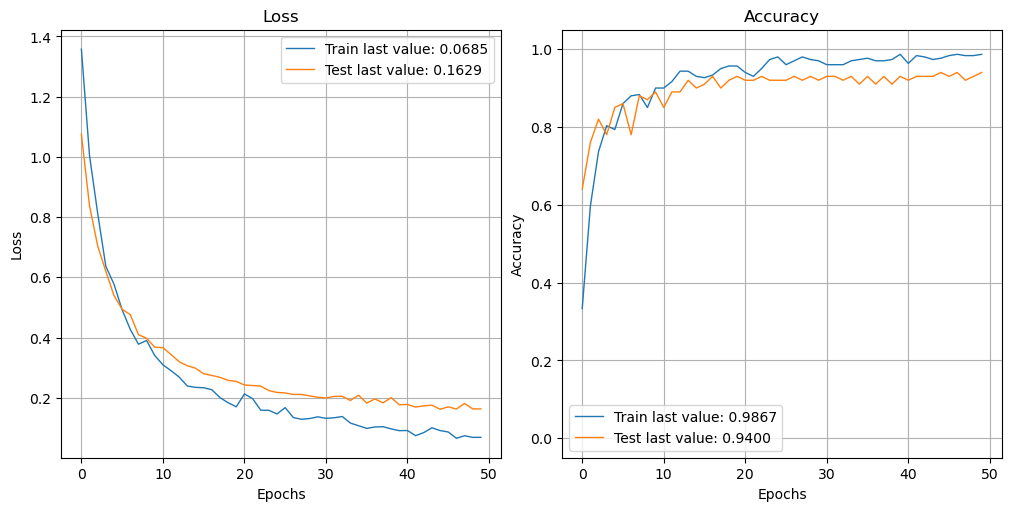

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()